In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!sudo rm -f /etc/boto.cfg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import saving_train
import loading_ds_train

import loading_ds_test
import saving_test

In [2]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [3]:
## Optional: remove sliced images from directory if necessary
# !rm -r 'data/091'
# !rm -r 'data/094'

In [4]:
training_image_path_list = ['tumor_094.tif',
                            'tumor_091.tif',
                            'tumor_031.tif',
                            'tumor_078.tif',
                            'tumor_081.tif',
                            'tumor_064.tif',
                            'tumor_035.tif',
                            'tumor_075.tif',
                            'tumor_019.tif',
                            'tumor_084.tif',
                            'tumor_012.tif',
                            'tumor_059.tif']

validation_image_path_list = ['tumor_101.tif',
                              'tumor_023.tif',
                              'tumor_091.tif',
                              'tumor_110.tif']

testing_image_path_list = ['tumor_038.tif',
                           'tumor_094.tif',
                           'tumor_057.tif',
                           'tumor_078.tif']

In [ ]:
saving_train.train_part_1(training_image_path_list, num_pixels = 64, num_level = 3)

tumor_094.tif tumor_094_mask.tif
tumor_091.tif tumor_091_mask.tif
tumor_031.tif tumor_031_mask.tif
tumor_078.tif tumor_078_mask.tif
tumor_081.tif tumor_081_mask.tif
tumor_064.tif tumor_064_mask.tif
tumor_035.tif tumor_035_mask.tif
tumor_075.tif tumor_075_mask.tif
tumor_019.tif tumor_019_mask.tif


In [ ]:
saving_train.save_second_level(training_image_path_list, input_level = 3, num_input_pixels = 64, 
                                                       output_level = 4, num_output_pixels = 64)

In [ ]:
ds_train, steps_per_epoch_train = loading_ds_train.train_part_2(training_image_path_list, num_level = 3)

In [ ]:
## Create sequential model with Imagenet base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
from tensorflow.keras import utils
model_gpu = utils.multi_gpu_model(model, gpus = 2)

In [10]:
## Compile and train model
model_gpu.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])
model_gpu.summary()

history = model_gpu.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch_train)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           vgg16_input[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           vgg16_input[0][0]                
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2)            14976930    lambda[0][0]                     
                                                                 lambda_1[0][0]                   
__________

{'loss': [0.5501624412006803, 0.2646603513922956], 'acc': [0.7534722222222222, 0.9131944444444444]}


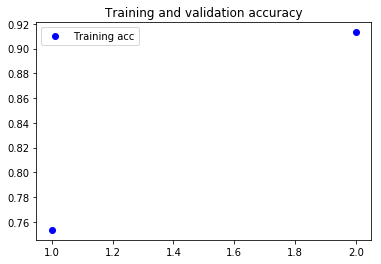

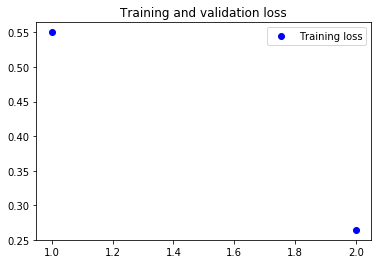

In [10]:
## Plot results
print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
# image from train set
image_path = 'tumor_091.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

tumor_091.tif tumor_091_mask.tif


In [12]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

Precision: 0.26082809973501203
Recall: 0.7997565621191994
F1: 0.3933660213102932
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     10964039      1651636
Reality 1       145923       582805
           Predicted 0  Predicted 1
Reality 0    82.162079    12.376994
Reality 1     1.093515     4.367412


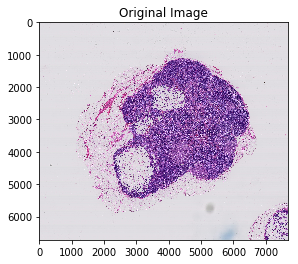

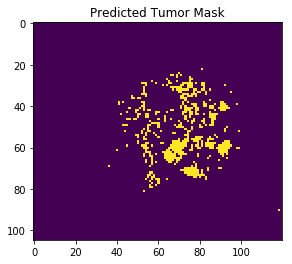

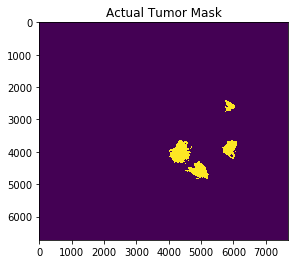

In [13]:
loading_ds_test.test_part_2(image_path, model, tissue_regions, slide_image_test, tumor_mask, image_depth, image_width, num_level = 3)

In [14]:
# new image from test set
# image_path = 'tumor_101.tif'
# image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)
# loading_ds_test.test_part_2(image_path,model,tissue_regions, slide_image_test, tumor_mask, image_depth, image_width)